In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
df = pd.read_csv(r"C:\MIDS\ADS_505_Applied_Data_Science_for_Business\ADS-505_Final_Project_Team_4\data\german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Feature Creation

In [83]:
# Create categorical feature for age
interval = (18, 25, 35, 60, 120)
# (18, 25) represents the interval for "Students" (ages 18 to 25).
# (25, 35) represents the interval for "Young" adults (ages 26 to 35).
# (35, 60) represents the interval for "Adults" (ages 36 to 60).
# (60, 120) represents the interval for "Seniors" (ages 61 to 120).
cats = ['Student', 'Young Adult', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

### Summary Statistics

In [5]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the dataset and store the summary
summary = analyze_data(df)
summary

Dataset Shape: (1000, 9)


,Name,dtypes,Missing,Uniques,First Value,Entropy,Skewness,Kurtosis,Min,Mean,Median,Max,Std,Outliers
0,Age,int64,0,53,67,5.27,1.02,0.59,19.0,35.546,33.0,75.0,11.375469,23.0
1,Sex,object,0,2,male,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Job,int64,0,4,2,1.41,-0.37,0.49,0.0,1.904,2.0,3.0,0.653614,370.0
3,Housing,object,0,3,own,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saving accounts,object,183,4,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Checking account,object,394,3,little,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Credit amount,int64,0,921,1169,9.80,1.95,4.27,250.0,3271.258,2319.5,18424.0,2822.736876,72.0
7,Duration,int64,0,33,6,3.76,1.09,0.91,4.0,20.903,18.0,72.0,12.058814,70.0
8,Purpose,object,0,8,radio/TV,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


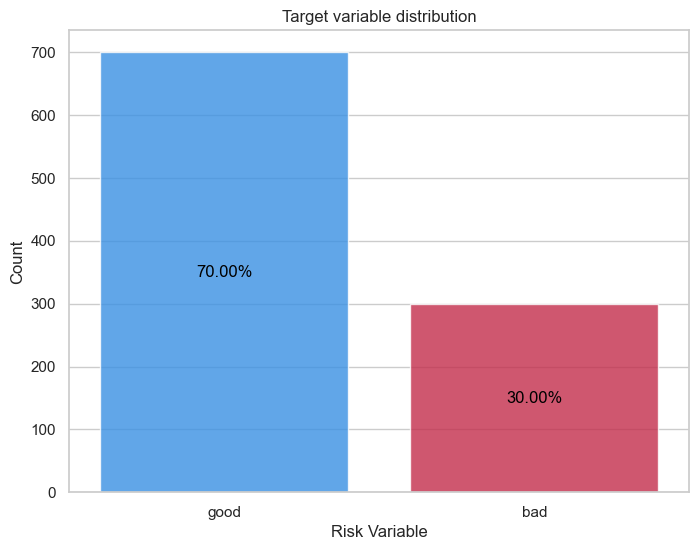

In [115]:
# Calculate the counts for 'good' and 'bad' credit
counts = df['Risk'].value_counts()

# Calculate the percentages
total_count = counts.sum()
percentages = (counts / total_count) * 100

# Create a bar chart with percentages in the center of each bar using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=counts.index, y=counts.values, palette=['dodgerblue', 'crimson'], alpha=0.8)
plt.xlabel('Risk Variable')
plt.ylabel('Count')
plt.title('Target variable distribution')

# Add percentages at the center of each bar
for bar, percentage in zip(ax.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.2f}%', 
             ha='center', va='center', fontsize=12, color='black')

plt.show()

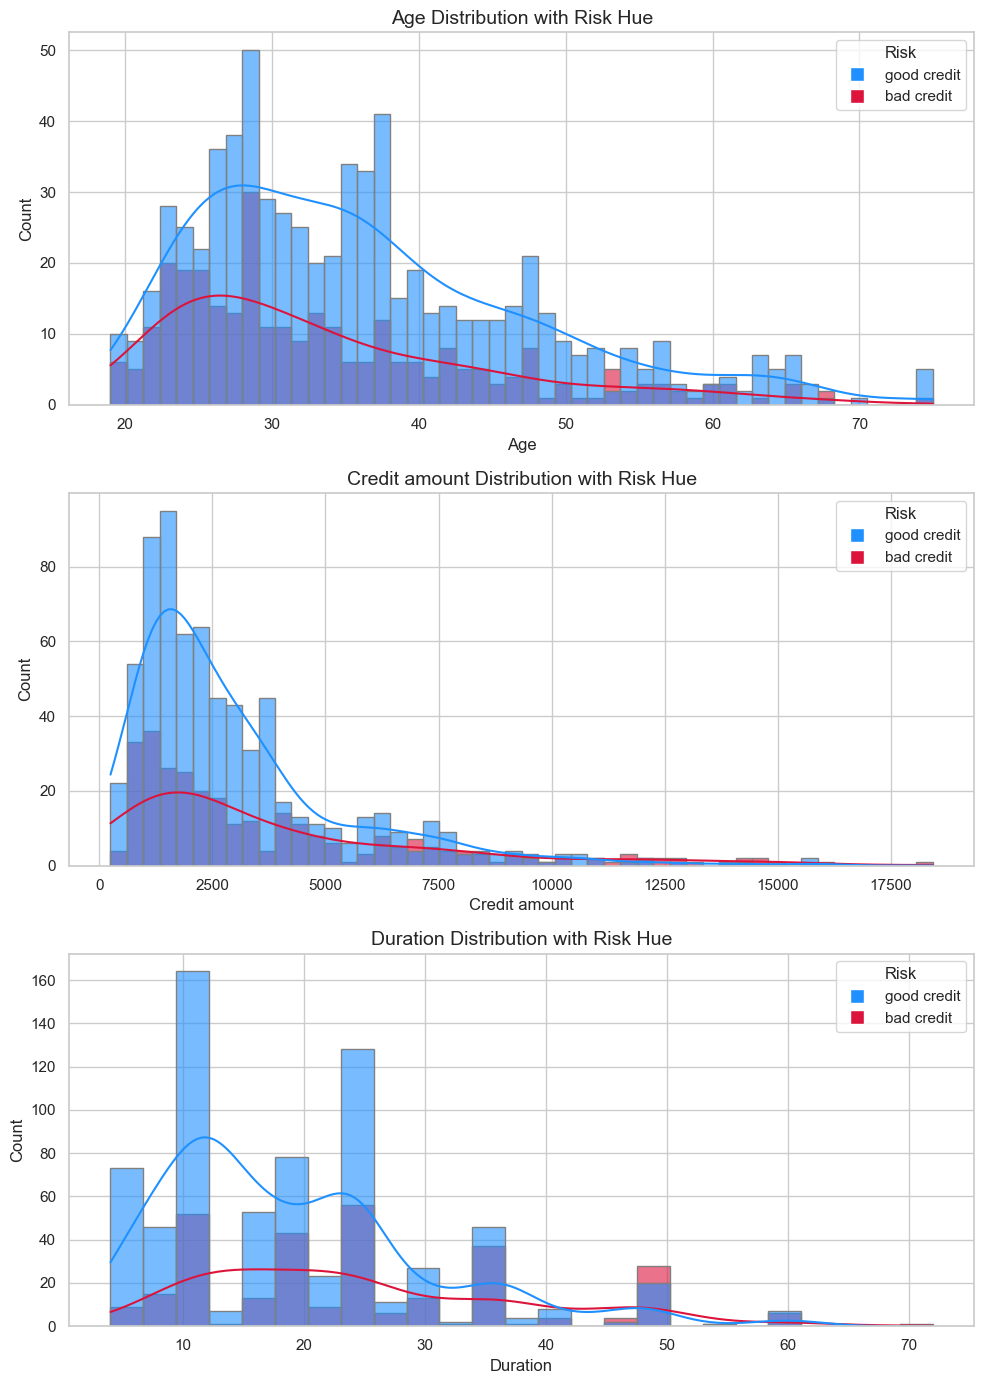

In [114]:
# Create a 3x1 grid of histograms with different bin counts
fig, axes = plt.subplots(3, 1, figsize=(10, 14))
# Columns to plot and their corresponding bin counts
columns_to_plot = ['Age', 'Credit amount', 'Duration']
bin_counts = [50, 50, 25]  # Adjust the bin counts as needed

# Loop through columns and create histograms with specified bin counts
for i, (column, bins) in enumerate(zip(columns_to_plot, bin_counts)):
    ax = axes[i]
    sns.histplot(data=df, x=column, hue='Risk', alpha=0.6, element='bars', bins=bins, 
                 palette={'good': 'dodgerblue', 'bad': 'crimson'}, edgecolor='grey', kde=True, legend=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Adjust the title font size
    ax.set_title(f'{column} Distribution with Risk Hue', fontsize=14)  # Change the fontsize here
    
    legend_labels = ['good credit', 'bad credit']
    legend_colors = ['dodgerblue', 'crimson']
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, title='Risk')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

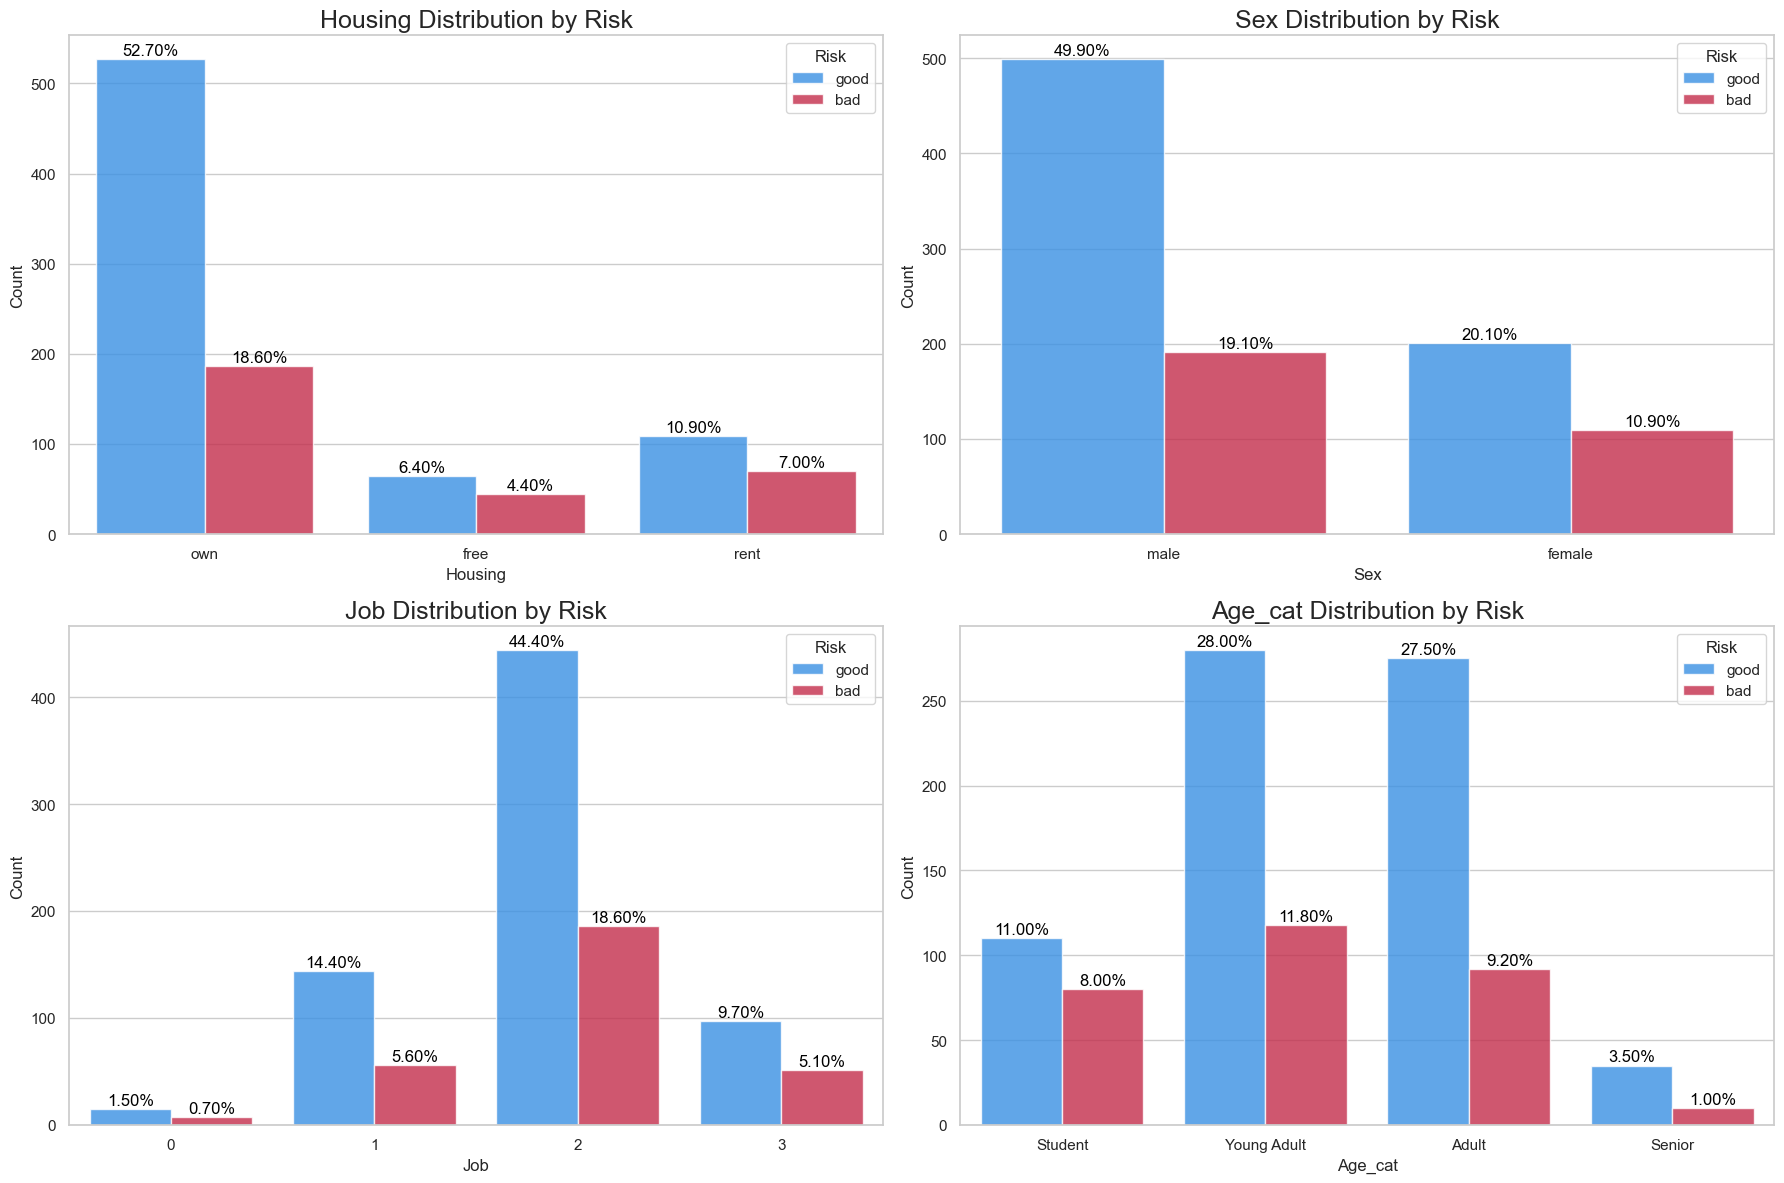

In [108]:
# Create a 2x2 grid of count plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# Columns to plot
columns_to_plot = ['Housing', 'Sex', 'Job', 'Age_cat']

# Loop through columns and create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = sns.countplot(data=df, x=column, hue='Risk', alpha=0.8, palette={'good': 'dodgerblue', 'bad': 'crimson'}, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Distribution by Risk', fontsize=18)  
    
    # Add percentages on top of the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / len(df) * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', fontsize=12, color='black')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend(title='Risk', loc='upper right')
plt.show()